# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import string
import re
import spacy

import torch
import torchtext
import torch.nn.functional as F
import torch.nn as nn

from torch.nn.utils.rnn import pad_sequence
from torch.utils import data

from typing import List, Tuple
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer

In [2]:
seed_value = 42
np.random.seed(seed_value)
torch.manual_seed(42)

In [3]:
torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

device(type='cuda', index=1)

In [4]:
embedder = SentenceTransformer('distilbert-base-uncased')

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

No sentence-transformers model found with name C:\Users\thodo/.cache\torch\sentence_transformers\distilbert-base-uncased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\thodo/.cache\torch\sentence_transformers\distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Imdb Sentiment Dataset

In [5]:
imdb_df = pd.read_pickle("../../dataset/imdb/IMDB_Dataset.pkl")

with pd.option_context("display.max_colwidth", 400):
    display(imdb_df.head(5))

,review,sentiment,sentence_emb
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regard...",1,"[[0.09089168, -0.4312202, 0.1777808, 0.1753257, 0.010759091, -0.2005085, 0.27599016, 0.011884959, 0.1604453, 0.009299543, 0.015030084, -0.49475184, -0.065348625, 0.49401504, -0.23960969, 0.15926929, -0.20532832, 0.030412113, 0.05766108, -0.22485304, 0.27855358, -0.018322121, 0.13812914, 0.43427724, 0.060281295, -0.024984688, 0.0249288, 0.032104444, -0.04274006, 0.014333263, 0.26901242, 0.08142..."
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the ref...",1,"[[0.2853191, 0.057061363, 0.042166166, 0.13712347, 0.17624079, -0.15170047, 0.24842091, 0.17267507, -0.31290993, 0.023059662, 0.17683989, -0.09073657, 0.14903301, 0.3341152, -0.48877758, 0.20374289, -0.041120946, 0.011611046, 0.23244858, 0.10206763, 0.028922752, -0.18585025, -0.037554085, 0.13713314, -0.11816621, 0.03302314, -0.18856438, 0.013541361, -0.09795467, -0.2878638, 0.002981597, -0.23..."
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof...",1,"[[0.19506094, 0.097519375, 0.3727303, 0.2985809, 0.3672494, -0.5289307, 0.14659134, 0.5963879, -0.29258925, -0.08868644, 0.11438061, -0.51627177, 0.020654097, 0.63030845, -0.3607591, 0.2991171, 0.2333256, 0.010175151, -0.008443773, 0.07752572, 0.16881564, -0.219349, 0.049629763, 0.25214517, 0.16993673, -0.20031397, -0.13826323, 0.1332187, -0.09899445, -0.03486871, 0.23277263, 0.22499402, -0.30..."
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Paren...",0,"[[0.0427402, 0.12809429, 0.2550377, 0.05013602, 0.29409963, -0.26337156, 0.40411872, 0.48837852, -0.22514482, -0.19391909, 0.028690057, -0.44648886, -0.10186345, 0.4054166, -0.36775997, 0.24085608, 0.17206536, 0.13304281, -0.06260124, 0.21000642, 0.1427837, 0.020737944, 0.02691934, 0.22508955, 0.0688116, 0.072792776, -0.0029568062, -0.0058495323, 0.030911652, -0.11351004, 0.28191015, -0.059242..."
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a variation on the Arthur Schnitzler's play about the same theme, the director transfers the action t...",1,"[[0.1531858, 0.016678736, 0.13898519, -0.010198899, 0.5159583, -0.032689616, -0.0020918075, 0.10085743, -0.12875439, 0.008747719, -0.024052795, -0.39607537, -0.07622185, 0.41865686, 0.033066906, 0.22057773, -0.07895011, 0.09162722, -0.15987928, 0.022043578, 0.064352065, -0.1500818, 0.22927344, 0.2703989, -0.0029290563, 0.053

We clean the sentences and get their embeddings

In [6]:
cached_stopwords = stopwords.words("english")
nlp = spacy.load("en_core_web_sm")

def clean_text(text: str) -> str:

    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in cached_stopwords])
    text = re.sub("<br /><br />", "", text)
    text = re.sub("\\t", "", text)
    sentences = text.split(".")
    sentences_clean = [el for el in sentences if el != '']

    return sentences_clean

def encode_sentences(sentences: List) -> np.ndarray:
    return np.array([embedder.encode(sentence) for sentence in sentences]).squeeze()

In [7]:
if "sentence_emb" not in imdb_df.columns:
    clean_features = imdb_df["review"].map(clean_text)
    encoded_features = clean_features.map(encode_sentences)

    imdb_df.insert(2, "sentence_emb", encoded_features)
    imdb_df.to_pickle("../../dataset/imdb/IMDB_Dataset.pkl")

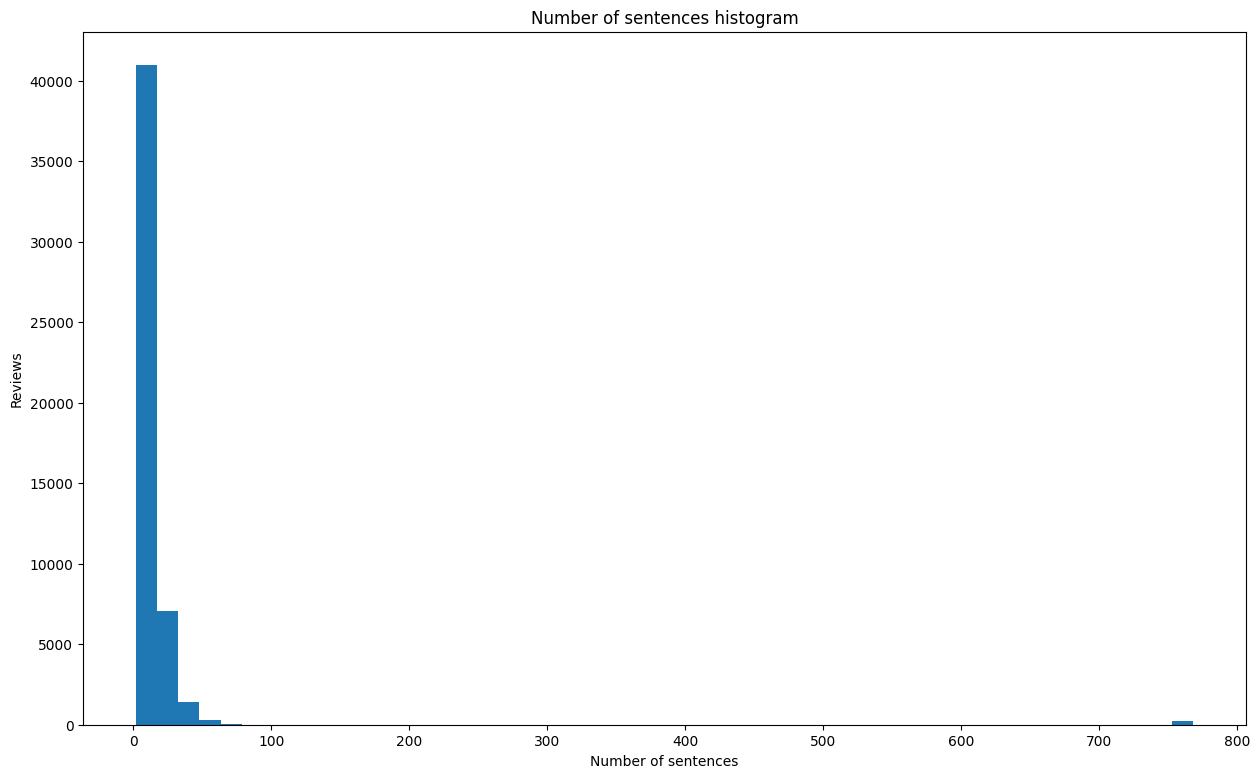

In [8]:
sentence_counts = imdb_df["sentence_emb"].apply(lambda x: len(x)).values

plt.figure(figsize=(15,9))
plt.title("Number of sentences histogram")
plt.xlabel("Number of sentences")
plt.ylabel("Reviews")
plt.hist(sentence_counts, bins=50)
plt.show()

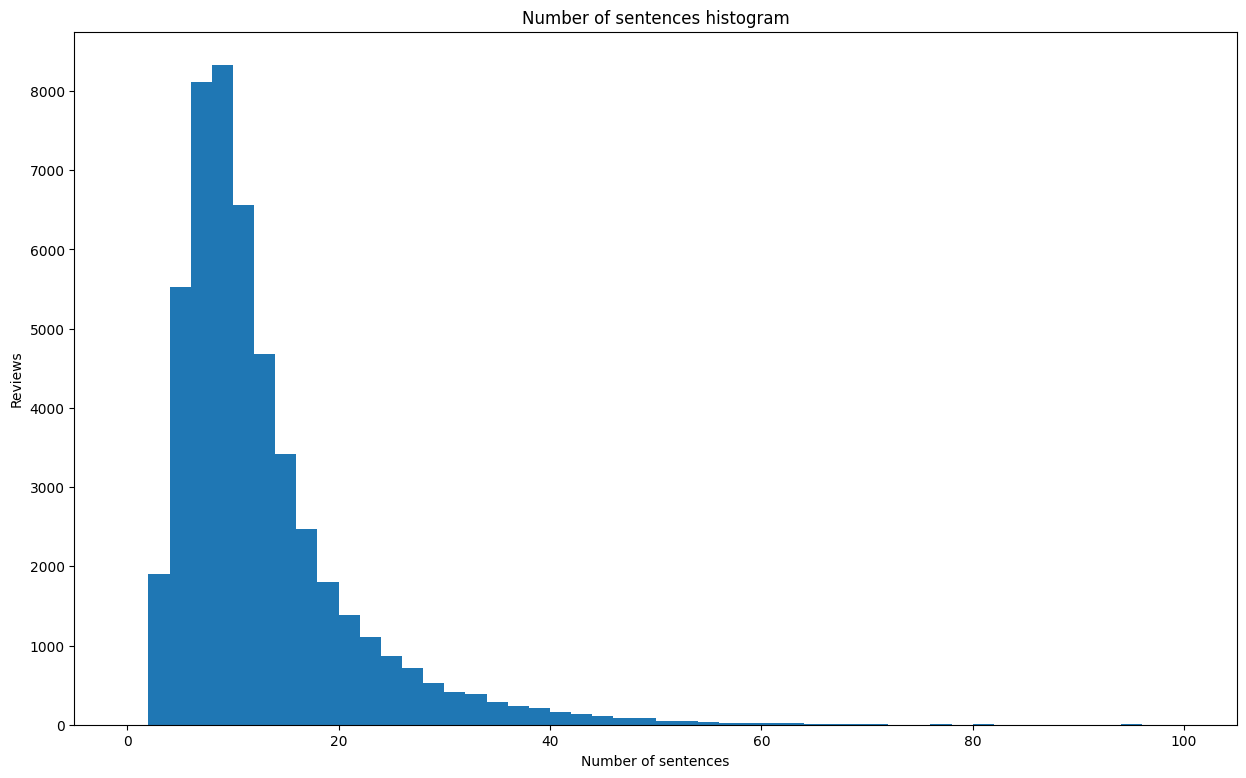

In [9]:
plt.figure(figsize=(15,9))
plt.title("Number of sentences histogram")
plt.xlabel("Number of sentences")
plt.ylabel("Reviews")
plt.hist(sentence_counts, bins=50, range=(0, 100))
plt.show()

We remove outliers in order to have more balanced padded sequences

In [10]:
MAX_SENTENCES = 40

imdb_df = imdb_df[imdb_df["sentence_emb"].apply(lambda x: len(x)) <= MAX_SENTENCES]
imdb_df = imdb_df.reset_index(drop=True)

In [11]:
imdb_df

,review,sentiment,sentence_emb
0,One of the other reviewers has mentioned that ...,1,"[[0.09089168, -0.4312202, 0.1777808, 0.1753257..."
1,A wonderful little production. <br /><br />The...,1,"[[0.2853191, 0.057061363, 0.042166166, 0.13712..."
2,I thought this was a wonderful way to spend ti...,1,"[[0.19506094, 0.097519375, 0.3727303, 0.298580..."
3,Basically there's a family where a little boy ...,0,"[[0.0427402, 0.12809429, 0.2550377, 0.05013602..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,"[[0.1531858, 0.016678736, 0.13898519, -0.01019..."
...,...,...,...
49029,I thought this movie did a down right good job...,1,"[[0.29426384, -0.030755641, 0.1506957, 0.05701..."
49030,"Bad plot, bad dialogue, bad acting, idiotic di...",0,"[[0.1237758, 0.34100595, 0.108573504, 0.204343..."
49031,I am a Catholic taught in parochial elementary...,0,"[[0.073877886, 0.26723263, -0.05526765, 0.0664..."
49032,I'm going to have to disagree with the previou...,0,"[[0.20457241, 0.006086063, -0.0152296955, -0.0..."


# Torch dataset preprocessing

In [12]:
class IMDB_Dataset(data.Dataset):
	def __init__(self, data_df: pd.DataFrame):
		super().__init__()
		x = data_df.sentence_emb.values
		y = data_df.sentiment.values
		self.x_train = list(map(lambda x: torch.tensor(x), x))
		self.y_train = list(map(lambda y: torch.tensor(y), y))

	def __len__(self):
		return len(self.y_train)

	def __getitem__(self, idx: int):
		return self.x_train[idx], self.y_train[idx]

In [13]:
def collate_fn(data: List[Tuple[torch.Tensor, torch.Tensor]]):

    data.sort(key=lambda x: x[0].shape[0], reverse=True)
    sequences, label = zip(*data)
    lengths = [len(seq) for seq in sequences]
    padded_seq = pad_sequence(sequences, batch_first=True, padding_value=0)
    
    return padded_seq, torch.from_numpy(np.array(lengths)), torch.from_numpy(np.array(label))

In [14]:
split = 0.8

imdb_df_train = imdb_df[:int(0.8 * len(imdb_df))]
imdb_df_val = imdb_df[int(0.8 * len(imdb_df)):]

In [15]:
BATCH_SIZE = 64

train_data = IMDB_Dataset(imdb_df_train)
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, drop_last=True)

val_data = IMDB_Dataset(imdb_df_val)
val_loader = data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, drop_last=True)

# Model

In [32]:
class LSTM_Classifier(nn.Module):

    def __init__(self, emb_size: int, hidden_size: int = 16, num_layers: int = 2, bidirectional: bool = False) -> None:
        super().__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(
            input_size=emb_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=0.1,
        )

        self.dense = nn.Linear(hidden_size, 16)
        #It will change to regressor
        self.classifier = nn.Linear(16, 1)
        self.tanh = nn.Tanh()

    def forward(self, x, hidden):
        
        batch_size = x.size(0)
        
        lstm_out, hidden_state = self.lstm(x, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_size)

        out = self.dense(lstm_out)
        out = self.classifier(out)
        out = self.tanh(out)

        out = out.view(batch_size, -1)
        out = out[:, -1]

        return out, hidden_state

    def init_hidden(self, batch_size):

        hidden = (torch.zeros((self.num_layers, batch_size, self.hidden_size)).cuda(),
                  torch.zeros((self.num_layers, batch_size, self.hidden_size)).cuda())
        
        return hidden

In [33]:
EMBEDDING_DIM = train_data.__getitem__(0)[0][0].shape[0]
NUM_LAYERS = 10
HIDDEN_DIM = 256

model = LSTM_Classifier(emb_size=EMBEDDING_DIM, hidden_size=HIDDEN_DIM, num_layers=NUM_LAYERS)
print(model)

LSTM_Classifier(
  (lstm): LSTM(768, 256, num_layers=10, batch_first=True, dropout=0.1)
  (dense): Linear(in_features=256, out_features=16, bias=True)
  (classifier): Linear(in_features=16, out_features=1, bias=True)
  (tanh): Tanh()
)


# Training

In [34]:
EPOCHS = 10

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)

model.cuda()
model.train()

cnt = 0

train_loss = []
val_loss = []

for epoch in range(EPOCHS):
    hidden_state = model.init_hidden(batch_size=BATCH_SIZE)

    for embeddings, _, labels in train_loader:
        cnt += 1

        embeddings = embeddings.cuda()
        labels = labels.cuda()

        hidden_state = tuple([each.data for each in hidden_state])

        model.zero_grad()

        output, hidden_state = model(embeddings, hidden_state)

        loss = criterion(output.squeeze(), labels.float())
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()

        if cnt % 100 == 0:
            val_h = model.init_hidden(BATCH_SIZE)
            val_losses = []
            model.eval()
            for embeddings, _, labels in val_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                #val_h = tuple([each.data for each in val_h])

                embeddings, labels = embeddings.cuda(), labels.cuda()  
                output, val_h = model(embeddings, val_h)
                v_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(v_loss.item())

            model.train()
            print(
                "Epoch: {}/{}...".format(epoch+1, EPOCHS),
                "Loss: {:.6f}...".format(loss.item()),
                "Val Loss: {:.6f}".format(np.mean(val_losses))
            )

    train_loss.append(round(loss.item(), 2))
    val_loss.append(np.mean(val_losses))

Epoch: 1/10... Loss: 176.166321... Val Loss: 130.710746
Epoch: 1/10... Loss: 144.389557... Val Loss: 129.108431
Epoch: 1/10... Loss: 117.225014... Val Loss: 127.062397
Epoch: 1/10... Loss: 126.551704... Val Loss: 125.298849
Epoch: 1/10... Loss: 125.212250... Val Loss: 124.933607
Epoch: 1/10... Loss: 139.714005... Val Loss: 125.174496
Epoch: 2/10... Loss: 118.670380... Val Loss: 124.283173
Epoch: 2/10... Loss: 115.578239... Val Loss: 124.019691
Epoch: 2/10... Loss: 135.979340... Val Loss: 125.507373
Epoch: 2/10... Loss: 104.430023... Val Loss: 124.009983
Epoch: 2/10... Loss: 142.136002... Val Loss: 123.806810
Epoch: 2/10... Loss: 113.613922... Val Loss: 123.906683
Epoch: 3/10... Loss: 103.187180... Val Loss: 123.780209
Epoch: 3/10... Loss: 84.911194... Val Loss: 124.577728
Epoch: 3/10... Loss: 108.652496... Val Loss: 123.780160
Epoch: 3/10... Loss: 133.278015... Val Loss: 123.427149
Epoch: 3/10... Loss: 118.130234... Val Loss: 123.261969
Epoch: 3/10... Loss: 128.861633... Val Loss: 123.

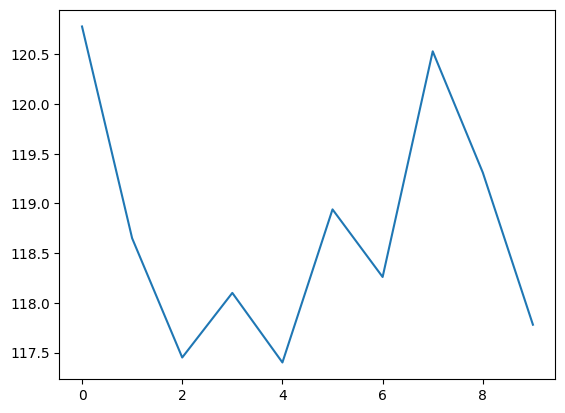

In [35]:
plt.plot(train_loss)
plt.show()

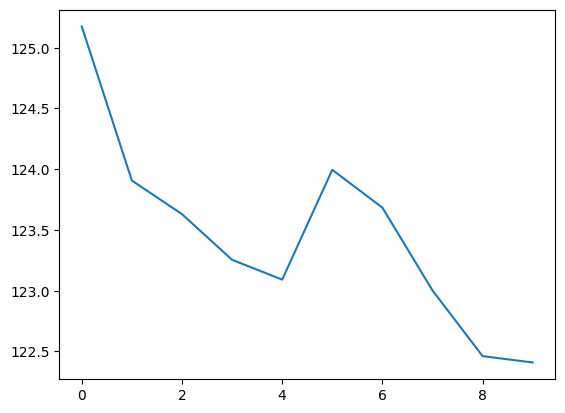

In [36]:
plt.plot(val_loss)
plt.show()